In [1]:
import matplotlib.pyplot as plt
import json
from glob import glob
import seaborn as sns
import pandas as pd
from fractions import Fraction
from matplotlib.patches import Patch

In [2]:
def load_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def create_ordered_dict_for_metric_and_alpha(metric, alpha, ordered_rules, ordered_n_cands):
    return {
        rule: {
            n_cands: load_file(f"./bt_profile_stats/{metric}/{n_cands:02d}/alpha_{alpha:.2f}/METRIC_{metric}__NCANDS_{n_cands}__ALPHA_{alpha:.2f}__TYPE_{rule}.json")
            for n_cands in ordered_n_cands
        }
        for rule in ordered_rules
    }
  

In [3]:
def build_plot_for_metric_and_alpha(metric, alpha, ordered_rules, ordered_n_cands, rule_color_map, ax, y_label=""):
    ordered_outputs = create_ordered_dict_for_metric_and_alpha(metric, alpha, ordered_rules, ordered_n_cands)
    
    df_list = []
    for n_cands in ordered_n_cands:
        df_data = [
            ordered_outputs[rule][n_cands] for rule in ordered_rules
        ]
        df = pd.DataFrame(df_data, index=ordered_outputs.keys()).T
        df = df.melt(var_name="rule", value_name="value")
        df["n_cands"] = n_cands
        df_list.append(df)

    long = pd.concat(df_list, ignore_index=True)



    sns.boxplot(
        data=long,
        x="n_cands",
        y="value",
        hue="rule",
        palette=rule_color_map,
        dodge=True,
        ax=ax,
        legend=False,
        fliersize=1,
        whis=[1, 99]
    )

    ax.set_ylabel(y_label)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"Metric: {y_label}, $\\alpha$={Fraction(alpha).limit_denominator()}") 

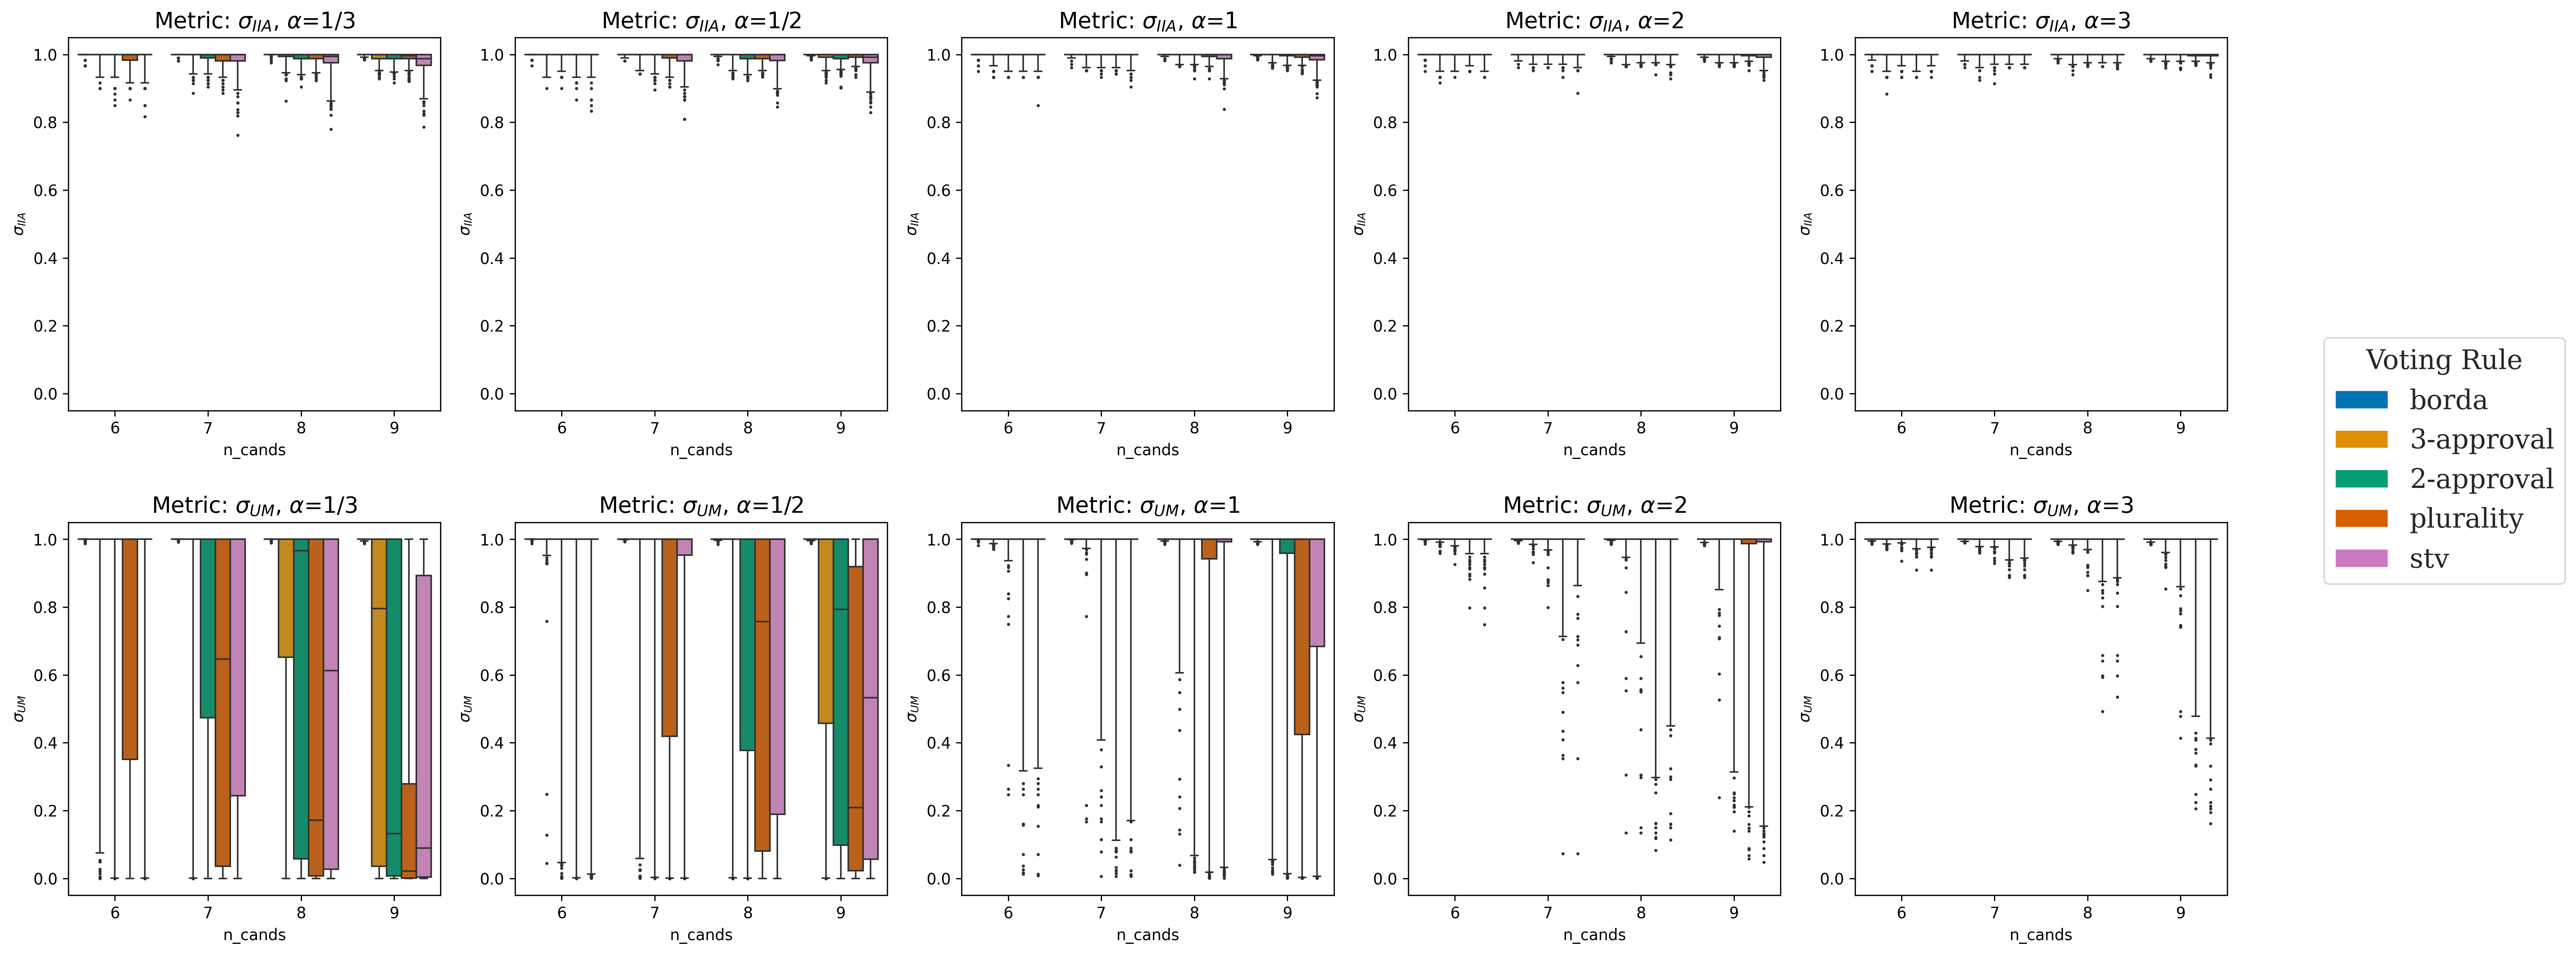

In [4]:
all_rules = ["borda", "3-approval", "2-approval", "plurality", "stv"]
cand_counts = list(range(6, 10))
alpha_values = [1/3, 1/2, 1, 2, 3]
# alpha_values = [1/3, 1/2]
metric_label_pairs = [
    ("sigma_IIA", "$\sigma_{IIA}$"),
    ("sigma_UM", "$\sigma_{UM}$"),]

scale = 1
fig, ax = plt.subplots(
    2, len(alpha_values), 
    figsize=(5*len(alpha_values)*scale, 10*scale), 
    dpi=300,
    gridspec_kw={"hspace": 0.3}
)
sns.set_theme(style="whitegrid", context="notebook", font="serif", font_scale=1.2)
palette = sns.color_palette("colorblind", len(all_rules))
rule_color_map = dict(zip(all_rules, palette))

for alpha_idx, alpha in enumerate(alpha_values):
    for idx, (metric, y_label) in enumerate(metric_label_pairs):
        build_plot_for_metric_and_alpha(
            metric, 
            alpha, 
            all_rules, 
            cand_counts, 
            rule_color_map, 
            ax[idx][alpha_idx], 
            y_label=y_label
        )

legend_patches = [Patch(facecolor=rule_color_map[r], label=r) for r in all_rules]
fig.legend(
    handles=legend_patches,
    title="Voting Rule",
    loc="center left",
    bbox_to_anchor=(0.93, 0.5),
    frameon=True,
    fontsize='large',
    title_fontsize='large'
)
plt.savefig("./plots/simulated_BT_plots.png", bbox_inches='tight', dpi=300)
